### Analisis Database Olist menggunakan SQLite dan Pandas

Pada proyek ini, kita akan melakukan analisis data terhadap database "Olist.db" dengan menggunakan  SQLite dan library Pandas dari Python. Berikut adalah langkah-langkahnya:

1. Membuat ERD
ERD merupakan gambaran hubungan antara tabel dalam database. Berikut adalah diagram ERD untuk databse "Olist.db":

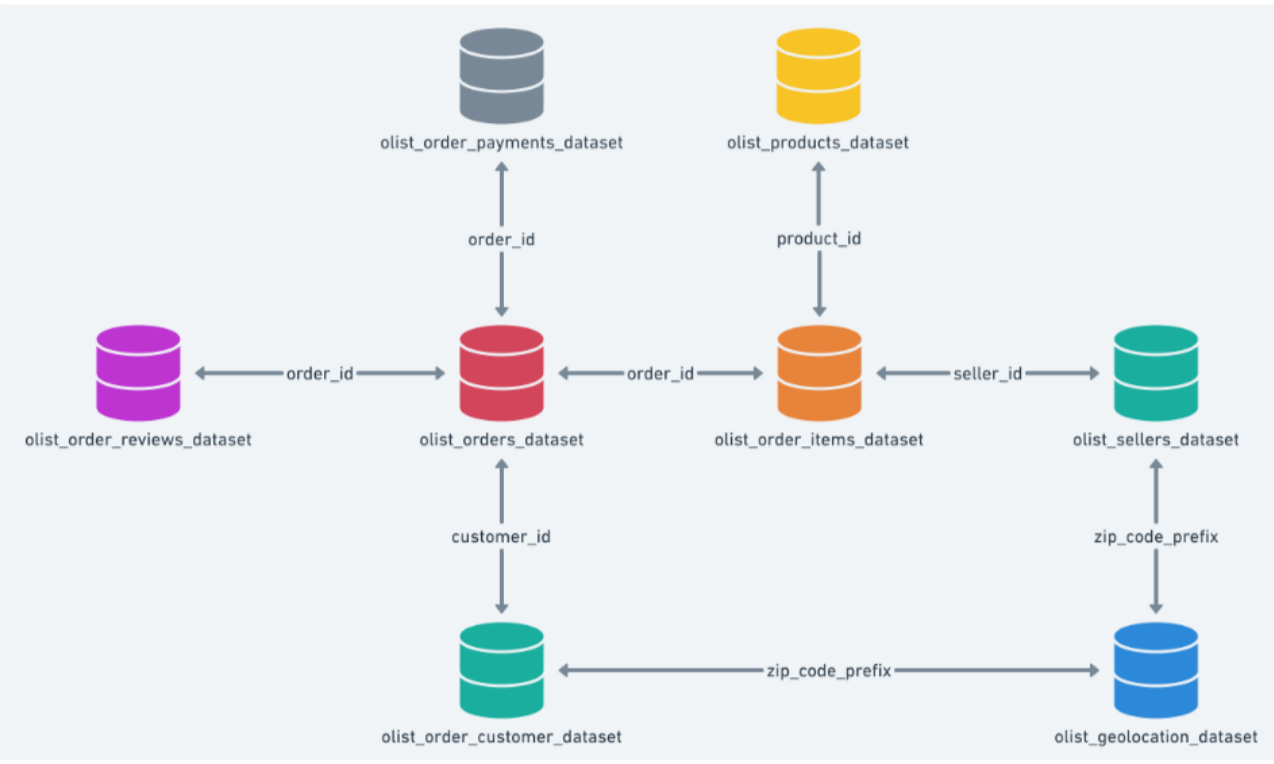

Terdapat 9 tabel dalam database ini yaitu:

- olist_order_dataset
- olist_order_customer_dataset
- olist_order_reviews_dataset
- olist_order_payments_dataset
- olist_order_items_dataset
- olist_products_dataset
- olist_sellers_dataset
- olist_geolocation_dataset
- product_category_name_translation

Setiap tabel memiliki primary key yang digunakan sebagai foreign key di tabel lainnya untuk menjaga integritas referensial. Tabel `product_category_name_translation` berisi kategori produk dalam bahasa Inggris dan Portugis untuk memudahkan analisis data.

In [60]:
# Import library
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Membuat koneksi dengan database
conn = sqlite3.connect('olist.db')

# Membaca tabel menjadi dataframe
df_order = pd.read_sql_query("SELECT * FROM olist_order_dataset", conn)
df_customer = pd.read_sql_query("SELECT * FROM olist_order_customer_dataset", conn)
df_reviews = pd.read_sql_query("SELECT * FROM olist_order_reviews_dataset", conn)
df_payments = pd.read_sql_query("SELECT * FROM olist_order_payments_dataset", conn)
df_items = pd.read_sql_query("SELECT * FROM olist_order_items_dataset", conn)
df_products = pd.read_sql_query("SELECT * FROM olist_products_dataset", conn)
df_sellers = pd.read_sql_query("SELECT * FROM olist_sellers_dataset", conn)
df_geolocation = pd.read_sql_query("SELECT * FROM olist_geolocation_dataset", conn)
df_category = pd.read_sql_query("SELECT * FROM product_category_name_translation", conn)

In [61]:
# Eksplorasi dan Pemrosesan Data
# Bergabungkan tabel yang relevan
orders_customers = pd.merge(df_order, df_customer, on='customer_id')
orders_reviews = pd.merge(orders_customers, df_reviews, on='order_id')
orders_payments = pd.merge(orders_reviews, df_payments, on='order_id')
orders_items = pd.merge(orders_payments, df_items, on='order_id')
orders_products = pd.merge(orders_items, df_products, on='product_id')
orders_sellers = pd.merge(orders_products, df_sellers, on='seller_id')
complete_data = pd.merge(orders_sellers, df_category, on='product_category_name')

C:\Users\ASUS\AppData\Local\Temp\ipykernel_18280\3902744658.py:5: FutureWarning: Passing 'suffixes' which cause duplicate columns {'index_x'} in the result is deprecated and will raise a MergeError in a future version.
  orders_payments = pd.merge(orders_reviews, df_payments, on='order_id')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_18280\3902744658.py:7: FutureWarning: Passing 'suffixes' which cause duplicate columns {'index_x'} in the result is deprecated and will raise a MergeError in a future version.
  orders_products = pd.merge(orders_items, df_products, on='product_id')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_18280\3902744658.py:9: FutureWarning: Passing 'suffixes' which cause duplicate columns {'index_x'} in the result is deprecated and will raise a MergeError in a future version.
  complete_data = pd.merge(orders_sellers, df_category, on='product_category_name')


In [62]:
# Melakukan pengecekan data
# Identifikasi NaN, duplicate data, outlier, dan inconsistent format
print("Info data:\n")
print(complete_data.info())
print("\nData duplikat:\n")
print(complete_data.duplicated().sum())

Info data:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115609 entries, 0 to 115608
Data columns (total 48 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   index_x                        115609 non-null  int64  
 1   order_id                       115609 non-null  object 
 2   customer_id                    115609 non-null  object 
 3   order_status                   115609 non-null  object 
 4   order_purchase_timestamp       115609 non-null  object 
 5   order_approved_at              115595 non-null  object 
 6   order_delivered_carrier_date   114414 non-null  object 
 7   order_delivered_customer_date  113209 non-null  object 
 8   order_estimated_delivery_date  115609 non-null  object 
 9   index_y                        115609 non-null  int64  
 10  customer_unique_id             115609 non-null  object 
 11  customer_zip_code_prefix       115609 non-null  int64  
 12  customer_city     

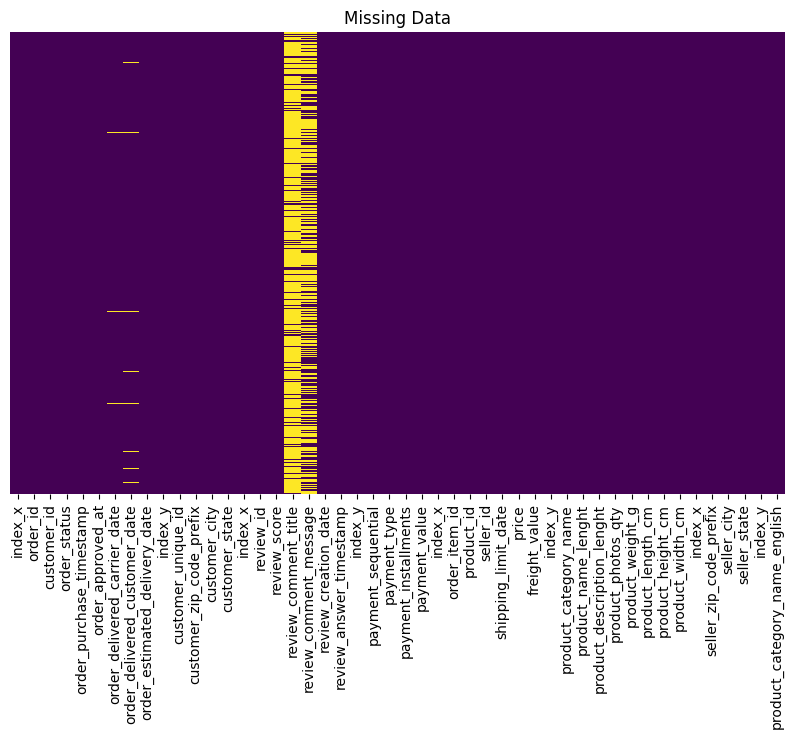

In [63]:
# Visualisasi missing data
plt.figure(figsize=(10, 6))
sns.heatmap(complete_data.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title("Missing Data")
plt.show()

In [64]:
# Menangani Missing Data
complete_data.dropna(inplace=True)

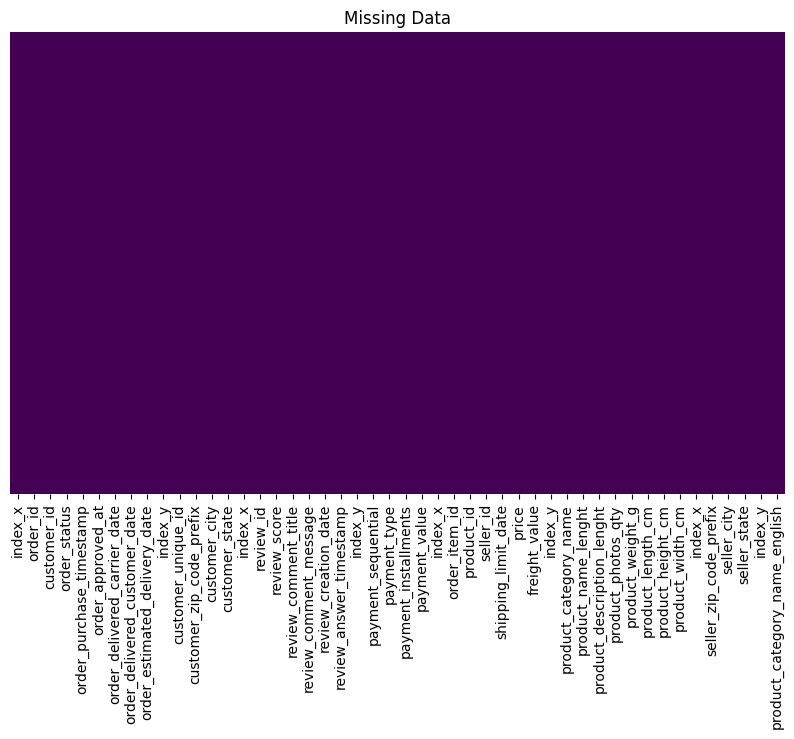

In [65]:
# Visualisasi setelah penanganan missing data
plt.figure(figsize=(10, 6))
sns.heatmap(complete_data.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title("Missing Data")
plt.show()

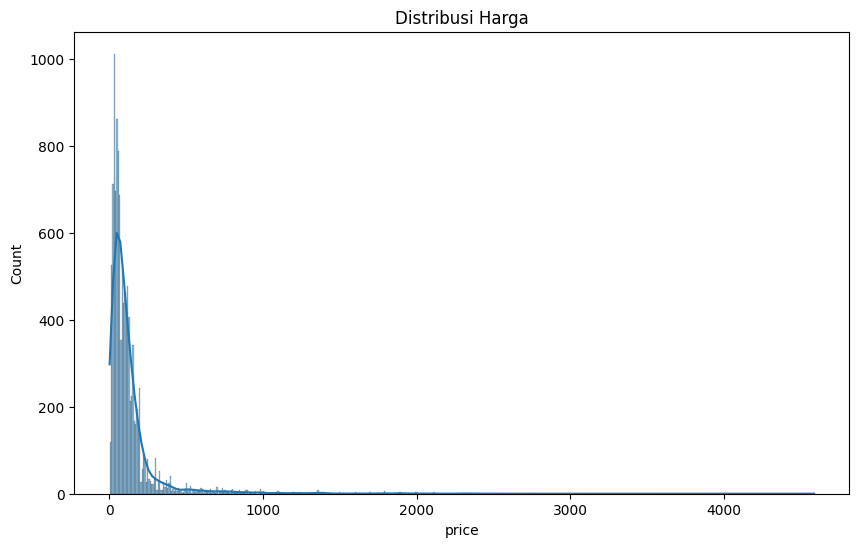

In [66]:
# Menangani Inconsistent Format
# (Contoh: Mengubah format tanggal menjadi format yang konsisten)
complete_data['order_purchase_timestamp'] = pd.to_datetime(complete_data['order_purchase_timestamp'])

# Visualisasi outlier distribusi harga
plt.figure(figsize=(10, 6))
sns.histplot(complete_data['price'], kde=True)
plt.title("Distribusi Harga")
plt.show()

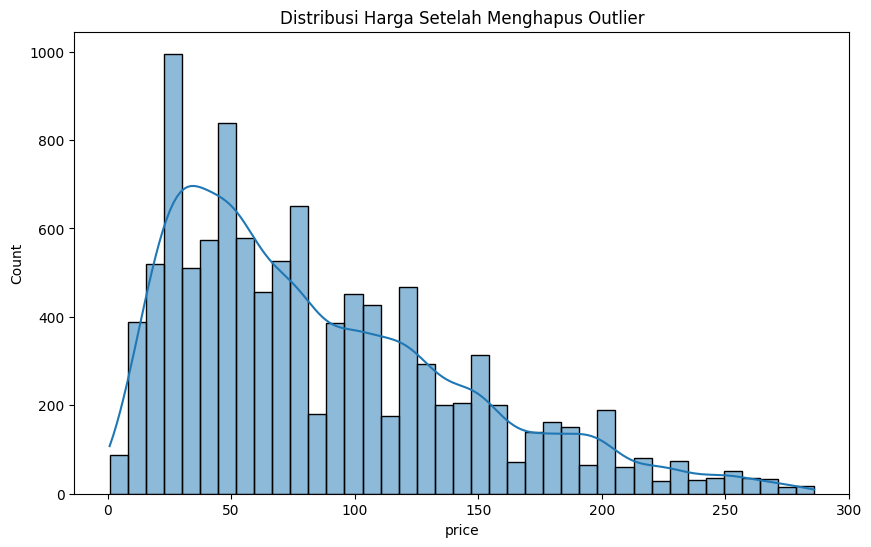

In [67]:
# Menangani Outliers
# (Contoh: Menggunakan IQR untuk mengidentifikasi dan menghapus outlier pada harga)
Q1 = complete_data['price'].quantile(0.25)
Q3 = complete_data['price'].quantile(0.75)
IQR = Q3 - Q1
price_outliers = complete_data[(complete_data['price'] < (Q1 - 1.5 * IQR)) | (complete_data['price'] > (Q3 + 1.5 * IQR))]
complete_data = complete_data[~complete_data.index.isin(price_outliers.index)]

# Visualisasi distribusi harga setelah menghapus outlier
plt.figure(figsize=(10, 6))
sns.histplot(complete_data['price'], kde=True)
plt.title("Distribusi Harga Setelah Menghapus Outlier")
plt.show()

In [68]:
# Menangani Duplicate Data
complete_data.drop_duplicates(inplace=True)

# Convert date columns to datetime format
complete_data['order_delivered_customer_date'] = pd.to_datetime(complete_data['order_delivered_customer_date'])
complete_data['order_purchase_timestamp'] = pd.to_datetime(complete_data['order_purchase_timestamp'])

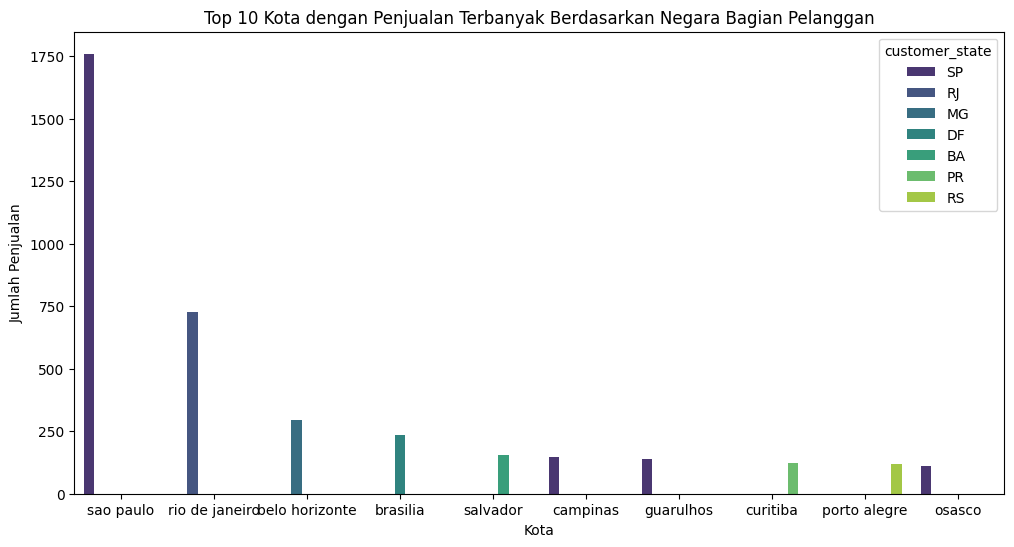

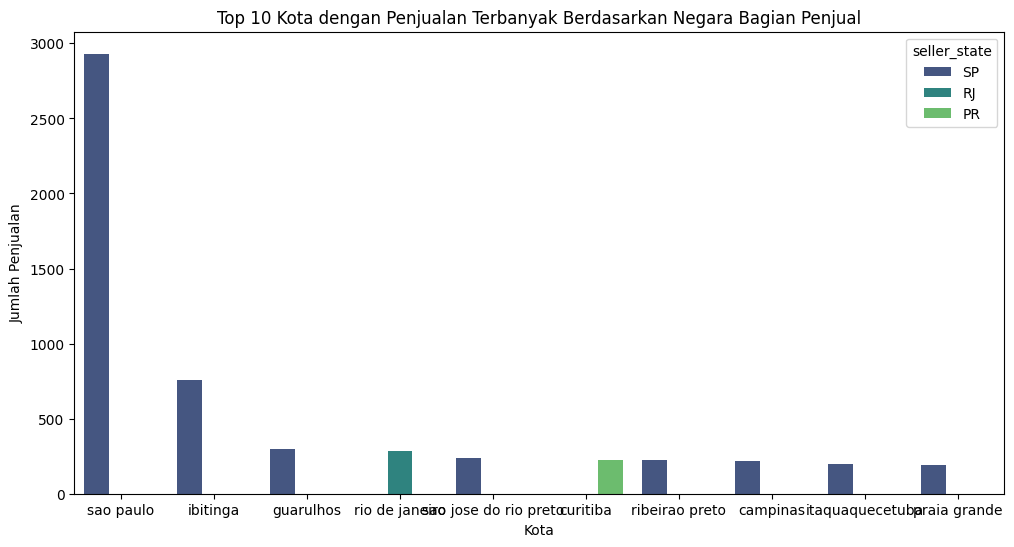

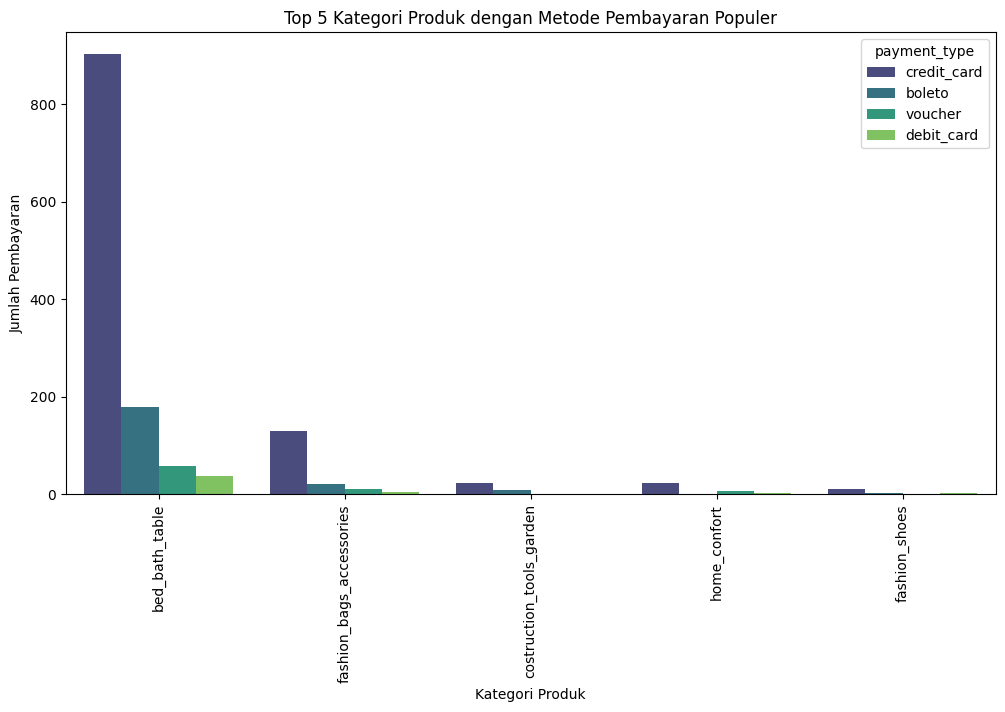

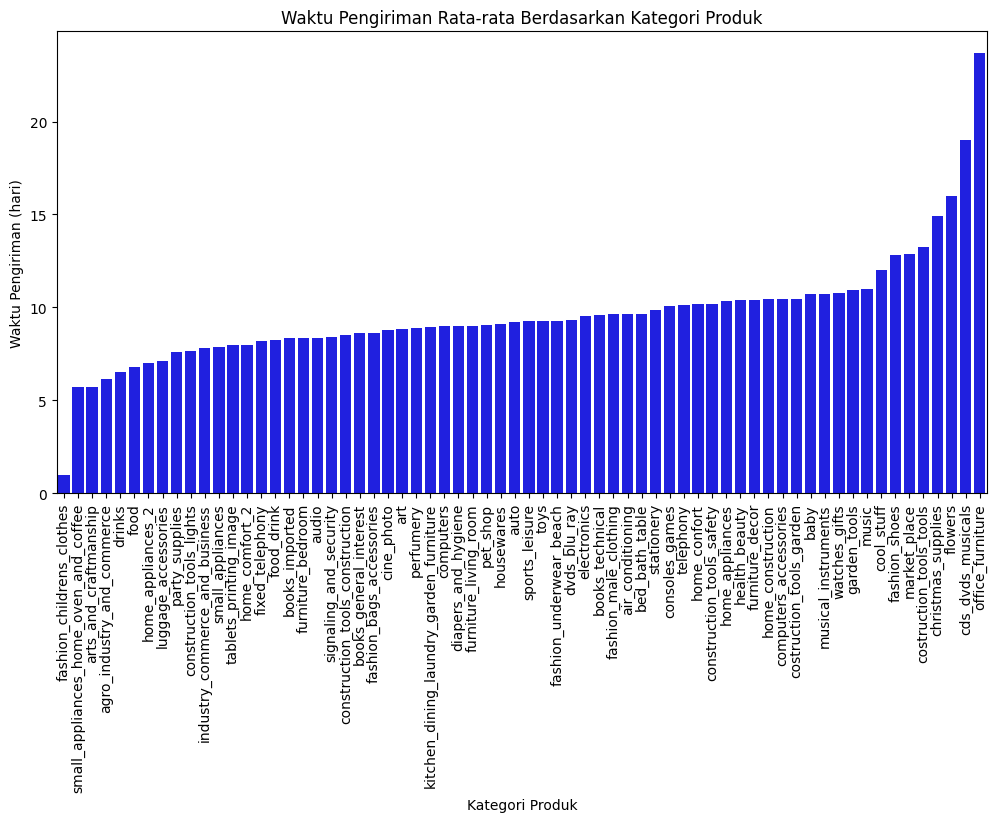

In [69]:
# Analisis jumlah penjualan berdasarkan kota dan negara bagian pelanggan.
sales_by_city_state = complete_data.groupby(['customer_city', 'customer_state']).size().reset_index(name='num_sales')
top_cities = sales_by_city_state.sort_values('num_sales', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_cities, x='customer_city', y='num_sales', hue='customer_state', palette='viridis')
plt.title("Top 10 Kota dengan Penjualan Terbanyak Berdasarkan Negara Bagian Pelanggan")
plt.xlabel("Kota")
plt.ylabel("Jumlah Penjualan")
plt.show()

# Analisis jumlah penjualan berdasarkan kota dan negara bagian penjual.
sales_by_seller_city_state = complete_data.groupby(['seller_city', 'seller_state']).size().reset_index(name='num_sales')
top_seller_cities = sales_by_seller_city_state.sort_values('num_sales', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_seller_cities, x='seller_city', y='num_sales', hue='seller_state', palette='viridis')
plt.title("Top 10 Kota dengan Penjualan Terbanyak Berdasarkan Negara Bagian Penjual")
plt.xlabel("Kota")
plt.ylabel("Jumlah Penjualan")
plt.show()

# Analisis metode pembayaran yang paling populer berdasarkan kategori produk.
popular_payment_by_category = complete_data.groupby(['product_category_name_english', 'payment_type']).size().reset_index(name='num_payments')
popular_payment_by_category = popular_payment_by_category.sort_values('num_payments', ascending=False)

# Ambil hanya data top 5 kategori produk
top_categories = popular_payment_by_category['product_category_name_english'].value_counts().head(5).index.tolist()
popular_payment_top_categories = popular_payment_by_category[popular_payment_by_category['product_category_name_english'].isin(top_categories)]

plt.figure(figsize=(12, 6))
sns.barplot(data=popular_payment_top_categories, x='product_category_name_english', y='num_payments', hue='payment_type', palette='viridis')
plt.title("Top 5 Kategori Produk dengan Metode Pembayaran Populer")
plt.xlabel("Kategori Produk")
plt.ylabel("Jumlah Pembayaran")
plt.xticks(rotation=90)
plt.show()

# Analisis waktu pengiriman rata-rata berdasarkan kategori produk.
complete_data['delivery_time'] = (complete_data['order_delivered_customer_date'] - complete_data['order_purchase_timestamp']).dt.days
avg_delivery_time_by_category = complete_data.groupby('product_category_name_english')['delivery_time'].mean().reset_index()
avg_delivery_time_by_category = avg_delivery_time_by_category.sort_values('delivery_time', ascending=True)

plt.figure(figsize=(12, 6))
sns.barplot(data=avg_delivery_time_by_category, x='product_category_name_english', y='delivery_time', color='blue')
plt.title("Waktu Pengiriman Rata-rata Berdasarkan Kategori Produk")
plt.xlabel("Kategori Produk")
plt.ylabel("Waktu Pengiriman (hari)")
plt.xticks(rotation=90)
plt.show()